In [2]:
cd ..

/home/compute/APS-360


In [16]:
import torch
import torch.nn as nn
import pandas as pd
from common import model
from common import evaluate
from torch.utils.data import Dataset, DataLoader

from transformer_images import *

from glob import glob
import numpy as np
import math

In [10]:
train, val = get_data_loaders(64)
test = DataLoader(animeDataset('test_imgs'), 64)

In [11]:
evaluate.evaluate(model, train), evaluate.evaluate(model, val), evaluate.evaluate(model, test)

(0.28815064378672, 0.2831317924621256, 0.3345378119134536)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.7227], device='cuda:0')


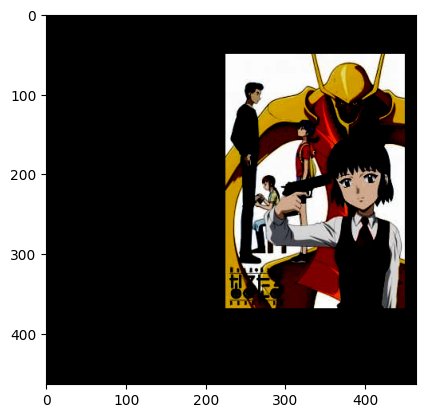

In [5]:
import matplotlib.pyplot as plt
for batch in train:
    img, rank = batch
    print(rank)
    plt.imshow(img.to('cpu').squeeze().permute(1, 2, 0))
    break

In [6]:
ls = sorted(glob(f"training/VIT*"))
check_l = lambda l: ('_loss' not in l) and ('_logs' not in l) and ('plots' not in l)
ls = sorted([l for l in ls if check_l(l)])
ls[0]

'training/VITb_128_0.01_100_16_10_5_1_0'

In [5]:
def find_test_acc(l):
    training = []
    validation = []
    testing = []
    li = l.split('_')
    batch_size, lr, ne, p, d, attn, layer, epoch  = tuple(li[1:])
    batch_size, ne, layer, epoch, p, d, attn = int(batch_size), int(ne), int(layer), int(epoch), int(p), int(d), int(attn)
    lr = float(lr)
    model = ImageTransformer('VITeval', batch_size, lr, ne, p, d, layer, attn)
    model_path = l
    state = torch.load(model_path)
    model.load_state_dict(state)
    training = evaluate.evaluate(model, train)
    validation = evaluate.evaluate(model, val)
    testing = evaluate.evaluate(model, test)
    return training, validation, testing

tr, vl, tst = [], [], []
for l in ls:
    try:
        t, v, ts = find_test_acc(l)
        tr.append(t)
        vl.append(v)
        tst.append(ts)
    except:
        print(l)
        pass

In [6]:
np.argmin(tr), np.argmin(vl), np.argmin(tst)

(314, 314, 314)

In [8]:
tr[314], vl[314], tst[314], ls[314]

(0.00929703654287314,
 0.0024918077599853025,
 0.0023865038483116938,
 'training/VITp_64_0.01_100_4_10_5_1_54')

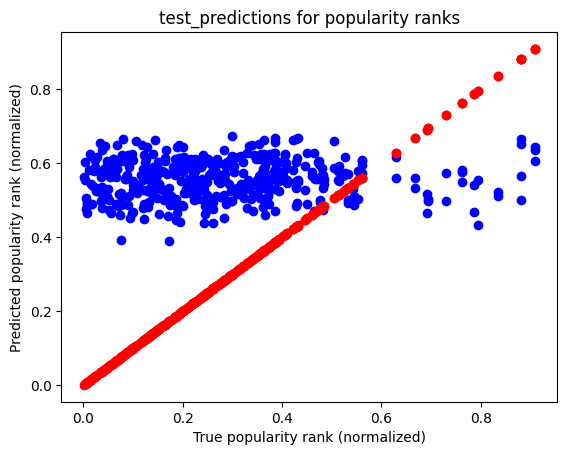

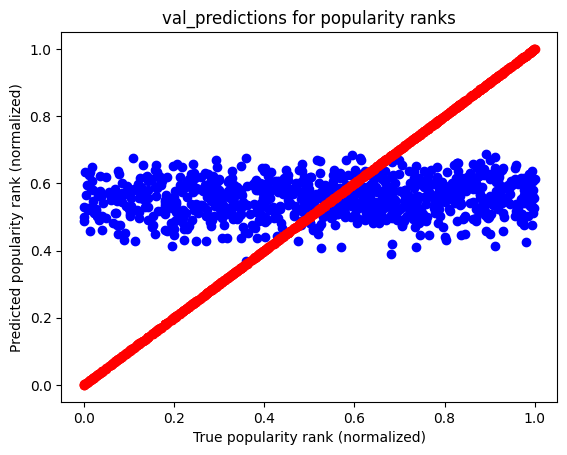

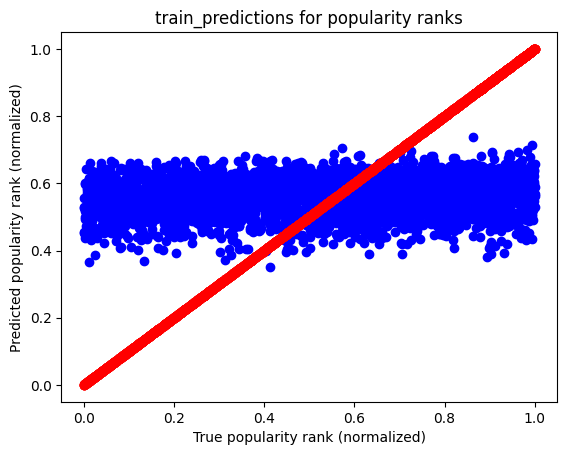

In [4]:
preds = []
labels_list = []

l = 'training/VITh_64_0.01_100_16_8_4_1_49'
li = l.split('_')
batch_size, lr, ne, p, d, attn, layer, epoch  = tuple(li[1:])
batch_size, ne, layer, epoch, p, d, attn = int(batch_size), int(ne), int(layer), int(epoch), int(p), int(d), int(attn)
lr = float(lr)

model = ImageTransformer('VITeval', batch_size, lr, ne, p, d, layer, attn)
model_path = l
state = torch.load(model_path)
model.load_state_dict(state)
model.to('cuda')

train, val = get_data_loaders(1)
# test_ds = animeDataset(df_test)
test = DataLoader(animeDataset('test_imgs'), 1)

for i, data in enumerate(test, 0):
    inputs, labels = data
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("test_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('VIT_test')
plt.show()

preds = []
labels_list = []
for i, data in enumerate(val, 0):
    inputs, labels = data
    # print(inputs)
    # print(labels)
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())   
plt.figure(2)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("val_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('VIT_val')
plt.show()

preds = []
labels_list = []
for i, data in enumerate(train, 0):
    inputs, labels = data
    # print(inputs)
    # print(labels)
    pred = model(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())   
plt.figure(3)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("train_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('VIT_train')
plt.show()

# Download all images & save them for easy loading

In [1]:
import PIL
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

In [2]:
cd ..

/home/compute/APS-360


## Get image urls

In [4]:
import pandas as pd

df = pd.read_csv('new_test_animes_data.csv')
df = df[['id', 'main_picture_medium', 'popularity']]
max = df['popularity'].max()
min = df['popularity'].min()
df['popularity'] = (df['popularity'] - min)/(max-min)

## Download images

In [5]:
def get_file(path, transforms):
    response = requests.get(path).content
    img = PIL.Image.open(io.BytesIO(response))
    img = img.convert('RGB')
    img = transforms(img)
    # plt.imshow(img.permute(1, 2, 0))
    return img

In [6]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomCrop(464, pad_if_needed=True),
])

In [7]:
imgs = []
for row in df.iterrows():
    unique_id, file_path, label = row[1]['id'], row[1]['main_picture_medium'], row[1]['popularity']
    # print(unique_id)
    imgs.append((get_file(file_path, image_transforms), label))

print('finished')

finished


In [8]:
import os
os.mkdir('new_test_imgs')

In [9]:
import pickle
for i, img in enumerate(imgs):
    pickle.dump(img, open(f'new_test_imgs/{i}', 'wb'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0


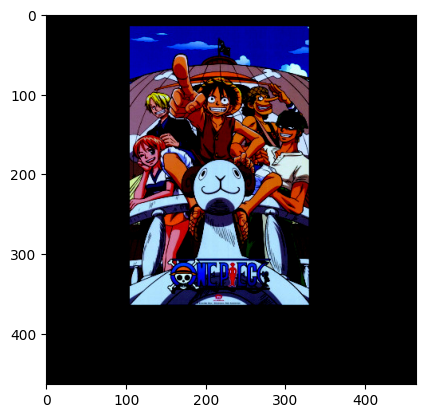

In [15]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt

img, rank = pickle.load(open(f'new_test_imgs/{0}', 'rb'))
# imshow needs the dimensions in a different order
plt.imshow(img.permute(1, 2, 0))
print(rank)

In [21]:
test = DataLoader(animeDataset('new_test_imgs'), 1)

l = 'training/VITh_64_0.01_100_16_8_4_1_49'
li = l.split('_')
batch_size, lr, ne, p, d, attn, layer, epoch  = tuple(li[1:])
batch_size, ne, layer, epoch, p, d, attn = int(batch_size), int(ne), int(layer), int(epoch), int(p), int(d), int(attn)
lr = float(lr)

net = ImageTransformer('VITeval', batch_size, lr, ne, p, d, layer, attn)
model_path = l
state = torch.load(model_path)
net.load_state_dict(state)
net.to('cuda')

evaluate.evaluate(net, test)

0.3065809770396089

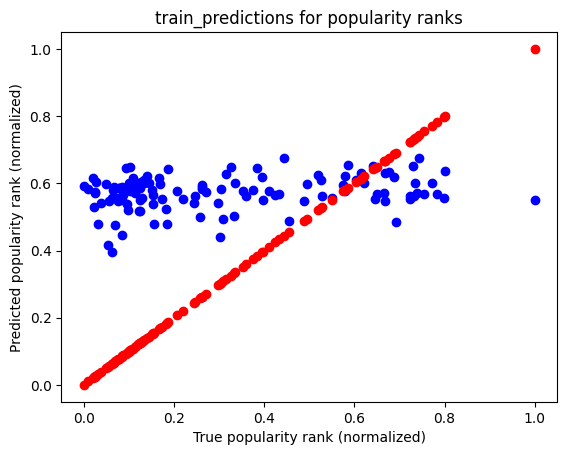

In [22]:
preds = []
labels_list = []
for i, data in enumerate(test, 0):
    inputs, labels = data
    # print(inputs)
    # print(labels)
    pred = net(inputs)
    preds.append(pred.item())
    labels_list.append(labels.item())   
plt.figure(3)
plt.plot(labels_list, preds, 'bo')
plt.plot(labels_list, labels_list, 'ro')
# plt.xlim(0.00, 1.00)
# plt.ylim(-0.00, 1.00)
plt.title("train_predictions for popularity ranks")
plt.xlabel("True popularity rank (normalized)")
plt.ylabel("Predicted popularity rank (normalized)")
plt.savefig('VIT_train')
plt.show()